In [10]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [11]:
# metadata 
# get sampleId, indId, group, batch, run from metadata tables
meta_file = '../snakemake/mage/filereport_read_run_PRJNA851328_tsv.txt'
meta = pd.read_csv(meta_file, sep='\t')

meta['sampleId'] = meta['indId'] = meta.experiment_alias.str.split('_', expand=True)[0]
meta['batch'] = meta.experiment_alias.str.split('_', expand=True)[1]


meta_file = '../snakemake/mage/sample_metadata_parsed.tsv'
df2 = pd.read_csv(meta_file, sep=' ', header=None)
df2.columns = ['sampleId', 'pop', 'continent', 'sex', 'sth', 'sth2']

meta = meta.merge(df2, how='left',
              on='sampleId')
meta['group'] = 1 # all the same group because we don't want to call sqtls separately for anything
meta[['sampleId', 'indId', 'group', 'batch', 'sex', 'pop', 'continent', 'experiment_alias']].head()
meta.head()

,run_accession,sample_accession,experiment_accession,study_accession,tax_id,scientific_name,instrument_platform,instrument_model,experiment_alias,fastq_bytes,...,bam_bytes,sampleId,indId,batch,pop,continent,sex,sth,sth2,group
0,SRR19762167,SAMN29221552,SRX15806983,PRJNA851328,9606,Homo sapiens,ILLUMINA,Illumina NovaSeq 6000,NA19704_batch11_rep1,1579585821;1583976496,...,NaN,NA19704,NA19704,batch11,ASW,AFR,female,SAMN29221552,SRS13499000,1
1,SRR19762172,SAMN29221523,SRX15806979,PRJNA851328,9606,Homo sapiens,ILLUMINA,Illumina NovaSeq 6000,NA19332_batch14_rep1,1969985537;1972458971,...,NaN,NA19332,NA19332,batch14,LWK,AFR,female,SAMN29221523,SRS13498996,1
2,SRR19762173,SAMN29221521,SRX15806977,PRJNA851328,9606,Homo sapiens,ILLUMINA,Illumina NovaSeq 6000,NA19317_batch15_rep1,1387073734;1388216521,...,NaN,NA19317,NA19317,batch15,LWK,AFR,male,SAMN29221521,SRS13498994,1
3,SRR19762174,SAMN29221520,SRX15806976,PRJNA851328,9606,Homo sapiens,ILLUMINA,Illumina NovaSeq 6000,NA19312_batch05_rep1,2814206811;2808461053,...,NaN,NA19312,NA19312,batch05,LWK,AFR,male,SAMN29221520,SRS13498993,1
4,SRR19762175,SAMN29221522,SRX15806978,PRJNA851328,9606,Homo sapiens,ILLUMINA,Illumina NovaSeq 6000,NA19323_batch11_rep1,1589064552;1592540862,...,NaN,NA19323,NA19323,batch11,LWK,AFR,female,SAMN29221522,SRS13498995,1


## Correlate gene expression counts per gene per sample

In [12]:
# regular gencode
df = pd.read_csv('../data/mage/v47_kallisto/matrix.abundance.genelevel.tpm.tsv', sep='\t')

# enhanced gencode
enh_df = pd.read_csv('../data/mage/enh_v47_kallisto/matrix.abundance.genelevel.tpm.tsv', sep='\t')

# get melted versions and merge
df = df.melt(id_vars=['gid'], 
        var_name='sample',
        value_name='tpm')
enh_df = enh_df.melt(id_vars=['gid'], 
        var_name='sample',
        value_name='tpm')

# merge and fill nans as 0s
df = df.merge(enh_df, how='outer',
              on=['gid', 'sample'],
              suffixes=('_v47', '_enh_v47'))
df.fillna(0, inplace=True)

# merge in metadata
df = df.merge(meta[['experiment_alias', 'pop', 'continent']],
              left_on='sample',
              right_on='experiment_alias')


In [16]:
# # compute correlation for each population or continental group
# cont_df = pd.DataFrame()
# for c in df.continent.unique():
#     temp = df.loc[df.continent==c]
#     x = temp.tpm_v47.tolist()
#     y = temp.tpm_enh_v47.tolist()
#     r, r_p = st.pearsonr(x, y)
#     rho, rho_p = st.spearmanr(x, y)
    
#     data = [[c, r, r_p, rho, rho_p]]
#     cols = ['continent', 'pearson_r', 'pearson_pval',
#             'spearman_rho', 'spearman_pval']
#     temp = pd.DataFrame(data=data, columns=cols)
#     cont_df = pd.concat([cont_df, temp], axis=0)

In [17]:
# compute correlation for each sample
cont_df = pd.DataFrame()
for s in df['sample'].unique():
    temp = df.loc[df['sample']==s]
    x = temp.tpm_v47.tolist()
    y = temp.tpm_enh_v47.tolist()
    r, r_p = st.pearsonr(x, y)
    rho, rho_p = st.spearmanr(x, y)
    
    data = [[s, r, r_p, rho, rho_p]]
    cols = ['sample', 'pearson_r', 'pearson_pval',
            'spearman_rho', 'spearman_pval']
    temp = pd.DataFrame(data=data, columns=cols)
    cont_df = pd.concat([cont_df, temp], axis=0)

In [21]:
# merge in metadata
cont_df = cont_df.merge(meta[['experiment_alias', 'pop', 'continent']],
              left_on='sample',
              right_on='experiment_alias')

In [22]:
cont_df.head()

,sample,pearson_r,pearson_pval,spearman_rho,spearman_pval,experiment_alias,pop,continent
0,NA19704_batch11_rep1,0.974976,0.0,0.868439,0.0,NA19704_batch11_rep1,ASW,AFR
1,NA19332_batch14_rep1,0.931483,0.0,0.856971,0.0,NA19332_batch14_rep1,LWK,AFR
2,NA19317_batch15_rep1,0.969830,0.0,0.864268,0.0,NA19317_batch15_rep1,LWK,AFR
3,NA19312_batch05_rep1,0.972717,0.0,0.849972,0.0,NA19312_batch05_rep1,LWK,AFR
4,NA19323_batch11_rep1,0.976105,0.0,0.864180,0.0,NA19323_batch11_rep1,LWK,AFR


In [23]:
cont_df.to_csv('mage_v47_v_enh_v47_gene_exp_corr.tsv', sep='\t')

<AxesSubplot:xlabel='continent', ylabel='pearson_r'>

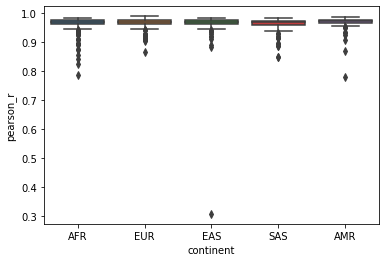

In [27]:
sns.boxplot(cont_df, 
            y='pearson_r',
            x='continent')

<AxesSubplot:xlabel='continent', ylabel='spearman_rho'>

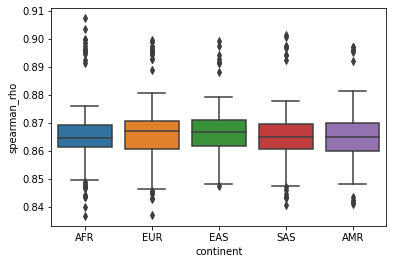

In [30]:
sns.boxplot(cont_df, 
            y='spearman_rho',
            x='continent')

In [29]:
cont_df.loc[cont_df.pearson_r==cont_df.pearson_r.min()]

,sample,pearson_r,pearson_pval,spearman_rho,spearman_pval,experiment_alias,pop,continent
445,HG01851_batch10_rep1,0.308571,0.0,0.859412,0.0,HG01851_batch10_rep1,KHV,EAS


In [31]:
cont_df.loc[cont_df.spearman_rho==cont_df.spearman_rho.min()]

,sample,pearson_r,pearson_pval,spearman_rho,spearman_pval,experiment_alias,pop,continent
637,HG03082_batch17_rep1,0.969307,0.0,0.836639,0.0,HG03082_batch17_rep1,MSL,AFR


In [35]:
temp = df.loc[df['sample'] == 'HG01851_batch10_rep1']
temp.head()

,gid,sample,tpm_v47,tpm_enh_v47,experiment_alias,pop,continent
35890140,ENSG00000000003.16,HG01851_batch10_rep1,0.010105,0.010165,HG01851_batch10_rep1,KHV,EAS
35890141,ENSG00000000005.6,HG01851_batch10_rep1,0.000000,0.000000,HG01851_batch10_rep1,KHV,EAS
35890142,ENSG00000000419.14,HG01851_batch10_rep1,80.476061,82.018866,HG01851_batch10_rep1,KHV,EAS
35890143,ENSG00000000457.14,HG01851_batch10_rep1,2.758748,2.779464,HG01851_batch10_rep1,KHV,EAS
35890144,ENSG00000000460.17,HG01851_batch10_rep1,8.399483,8.522866,HG01851_batch10_rep1,KHV,EAS


In [37]:
# sns.jointplot(temp, x='tpm_v47', y='tpm_enh_v47')

In [40]:
temp['ratio'] = (temp.tpm_enh_v47+1)/(temp.tpm_v47+1)

In [41]:
temp.loc[temp.ratio==temp.ratio.max()]

,gid,sample,tpm_v47,tpm_enh_v47,experiment_alias,pop,continent,ratio
35943862,ENSG00000211677.2_ENSG00000211662.2,HG01851_batch10_rep1,0.0,61926.0642,HG01851_batch10_rep1,KHV,EAS,61927.0642


In [44]:
# what types of genes are always overrepresnted in the enh. version?
temp = temp.sort_values(by='ratio', ascending=False)
temp.head()

,gid,sample,tpm_v47,tpm_enh_v47,experiment_alias,pop,continent,ratio
35943862,ENSG00000211677.2_ENSG00000211662.2,HG01851_batch10_rep1,0.0,61926.064200,HG01851_batch10_rep1,KHV,EAS,61927.064200
35943978,ENSG00000240041.1_ENSG00000211896.7,HG01851_batch10_rep1,0.0,25101.300000,HG01851_batch10_rep1,KHV,EAS,25102.300000
35943823,ENSG00000211592.8_ENSG00000211597.2,HG01851_batch10_rep1,0.0,4101.347254,HG01851_batch10_rep1,KHV,EAS,4102.347254
35945996,ENSG00000280800.1,HG01851_batch10_rep1,0.0,3122.970000,HG01851_batch10_rep1,KHV,EAS,3123.970000
35946050,ENSG00000281181.1,HG01851_batch10_rep1,0.0,3122.970000,HG01851_batch10_rep1,KHV,EAS,3123.970000
35945960,ENSG00000280614.1,HG01851_batch10_rep1,0.0,3122.970000,HG01851_batch10_rep1,KHV,EAS,3123.970000
35969890,LOC_000000001550,HG01851_batch10_rep1,0.0,1742.068000,HG01851_batch10_rep1,KHV,EAS,1743.068000
35969482,ENSG00000310376.1,HG01851_batch10_rep1,0.0,1683.599850,HG01851_batch10_rep1,KHV,EAS,1684.599850
35970751,novelGene_ENSG00000300403.1_AS,HG01851_batch10_rep1,0.0,1342.203210,HG01851_batch10_rep1,KHV,EAS,1343.203210
35952480,ENSG00000293320.1,HG01851_batch10_rep1,0.0,1324.448880,HG01851_batch10_rep1,KHV,EAS,1325.448880


In [47]:
# what types of genes are always overrepresnted in the enh. version?
df['ratio'] = (df.tpm_enh_v47+1)/(df.tpm_v47+1)
df = df.sort_values(by='ratio', ascending=False)
df.head(10)

,gid,sample,tpm_v47,tpm_enh_v47,experiment_alias,pop,continent,ratio
35943862,ENSG00000211677.2_ENSG00000211662.2,HG01851_batch10_rep1,0.0,61926.06420,HG01851_batch10_rep1,KHV,EAS,61927.06420
35943978,ENSG00000240041.1_ENSG00000211896.7,HG01851_batch10_rep1,0.0,25101.30000,HG01851_batch10_rep1,KHV,EAS,25102.30000
46509423,ENSG00000243466.1_ENSG00000211592.8,NA19789_batch12_rep1,0.0,20891.19206,NA19789_batch12_rep1,MXL,AMR,20892.19206
860303,ENSG00000211904.2_ENSG00000211899.10,NA18878_batch13_rep1,0.0,18295.52360,NA18878_batch13_rep1,YRI,AFR,18296.52360
18442497,ENSG00000240041.1_ENSG00000211899.10,NA18874_batch09_rep1,0.0,17270.54124,NA18874_batch09_rep1,YRI,AFR,17271.54124
13926011,ENSG00000243290.3_ENSG00000211592.8,NA19338_batch10_rep1,0.0,15132.88901,NA19338_batch10_rep1,LWK,AFR,15133.88901
23362334,ENSG00000254709.8_ENSG00000253451.1,NA19038_batch14_rep1,0.0,14041.70000,NA19038_batch14_rep1,LWK,AFR,14042.70000
6264058,ENSG00000242371.1_ENSG00000242076.3_ENSG000002...,NA20875_batch02_rep1,0.0,13199.20000,NA20875_batch02_rep1,GIH,SAS,13200.20000
60220263,ENSG00000243466.1_ENSG00000211592.8,HG02232_batch09_rep1,0.0,12396.61112,HG02232_batch09_rep1,IBS,EUR,12397.61112
28765953,ENSG00000240041.1_ENSG00000211899.10,HG02471_batch17_rep1,0.0,11973.06830,HG02471_batch17_rep1,ACB,AFR,11974.06830


## Ok, what about just from shared detected genes?

In [56]:
# regular gencode
df = pd.read_csv('../data/mage/v47_kallisto/matrix.abundance.genelevel.tpm.tsv', sep='\t')

# enhanced gencode
enh_df = pd.read_csv('../data/mage/enh_v47_kallisto/matrix.abundance.genelevel.tpm.tsv', sep='\t')


# get melted versions and merge
df = df.melt(id_vars=['gid'], 
        var_name='sample',
        value_name='tpm')
enh_df = enh_df.melt(id_vars=['gid'], 
        var_name='sample',
        value_name='tpm')

# fillna and drop all 0 count
df.fillna(0, inplace=True)
df = df.loc[df.tpm>0]
enh_df = enh_df.loc[enh_df.tpm>0]


# print(df.loc[(df.gid=='ENSG00000277651.1')&
#              (df['sample']=='HG03225_batch12_rep1')])
# print(enh_df.loc[(enh_df.gid=='ENSG00000277651.1')&
#              (enh_df['sample']=='HG03225_batch12_rep1')])
      

# merge and fill nans as 0s
df = df.merge(enh_df, how='inner',
              on=['gid', 'sample'],
              suffixes=('_v47', '_enh_v47'))

# merge in metadata
df = df.merge(meta[['experiment_alias', 'pop', 'continent']],
              left_on='sample',
              right_on='experiment_alias')


In [60]:
df.head()

,gid,sample,tpm_v47,tpm_enh_v47,experiment_alias,pop,continent
0,ENSG00000000003.16,NA19704_batch11_rep1,0.327475,0.307088,NA19704_batch11_rep1,ASW,AFR
1,ENSG00000000419.14,NA19704_batch11_rep1,105.811866,99.638334,NA19704_batch11_rep1,ASW,AFR
2,ENSG00000000457.14,NA19704_batch11_rep1,2.741992,2.554472,NA19704_batch11_rep1,ASW,AFR
3,ENSG00000000460.17,NA19704_batch11_rep1,7.209873,6.778397,NA19704_batch11_rep1,ASW,AFR
4,ENSG00000000938.13,NA19704_batch11_rep1,32.597670,30.749290,NA19704_batch11_rep1,ASW,AFR


In [57]:
# compute correlation for each sample
cont_df = pd.DataFrame()
for s in df['sample'].unique():
    temp = df.loc[df['sample']==s]
    x = temp.tpm_v47.tolist()
    y = temp.tpm_enh_v47.tolist()
    r, r_p = st.pearsonr(x, y)
    rho, rho_p = st.spearmanr(x, y)
    
    data = [[s, r, r_p, rho, rho_p]]
    cols = ['sample', 'pearson_r', 'pearson_pval',
            'spearman_rho', 'spearman_pval']
    temp = pd.DataFrame(data=data, columns=cols)
    cont_df = pd.concat([cont_df, temp], axis=0)

In [61]:
# merge in metadata
cont_df = cont_df.merge(meta[['experiment_alias', 'pop', 'continent']],
              left_on='sample',
              right_on='experiment_alias')

In [62]:
cont_df.to_csv('mage_v47_v_enh_v47_shared_gene_exp_corr.tsv', sep='\t')

<AxesSubplot:xlabel='continent', ylabel='pearson_r'>

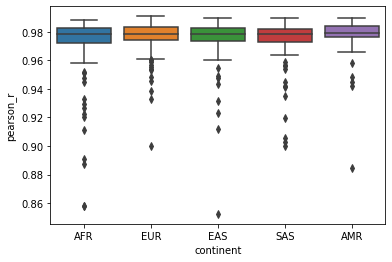

In [63]:
sns.boxplot(cont_df, 
            y='pearson_r',
            x='continent')

## How many more genes do we detect per sample using enhanced gencode?

In [69]:
min_tpm = 1

# regular gencode
df = pd.read_csv('../data/mage/v47_kallisto/matrix.abundance.genelevel.tpm.tsv', sep='\t')

# enhanced gencode
enh_df = pd.read_csv('../data/mage/enh_v47_kallisto/matrix.abundance.genelevel.tpm.tsv', sep='\t')

# get melted versions and merge
df = df.melt(id_vars=['gid'], 
        var_name='sample',
        value_name='tpm')
df['annot'] = 'v47'

enh_df = enh_df.melt(id_vars=['gid'], 
        var_name='sample',
        value_name='tpm')
enh_df['annot'] = 'enh_v47'

# merge and fill nans as 0s
df = pd.concat([df, enh_df], axis=0)
df.fillna(0, inplace=True)

# merge in metadata
df = df.merge(meta[['experiment_alias', 'pop', 'continent']],
              left_on='sample',
              right_on='experiment_alias')

# remove unexpressed genes
df = df.loc[df.tpm>=min_tpm]

In [70]:
# count up number of genes per sample
gb_cols = ['sample', 'pop', 'continent', 'annot']
keep_cols = gb_cols + ['gid']
df = df[keep_cols].groupby(gb_cols).nunique().reset_index()
df.head()

,sample,pop,continent,annot,gid
0,HG00096_batch16_rep1,GBR,EUR,enh_v47,14806
1,HG00096_batch16_rep1,GBR,EUR,v47,13290
2,HG00100_batch04_rep1,GBR,EUR,enh_v47,13200
3,HG00100_batch04_rep1,GBR,EUR,v47,12227
4,HG00105_batch13_rep1,GBR,EUR,enh_v47,14045


In [71]:
df.annot.unique()

array(['enh_v47', 'v47'], dtype=object)